## Model 1 - Location Prediction

In [3]:
import pandas as pd
import numpy as np
import math

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [4]:
#Ignore warnings 
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

## 1. Data Preparation


### 1.1. Phoenix Business Data

In [ ]:
raw_data = pd.read_csv('../../../data/phoenix_business_ws_rw_ffall_merged2.csv', skipinitialspace=True)

raw_data.head(1)

All the available attibutes in the given dataset. 

### 1.2. Data Selection

In [240]:
#dframe = raw_data[(raw_data['ffall']<=1500) & (raw_data['ffall']>=3)]
dframe = raw_data
dframe['totalStars'] = dframe['review_count'] * dframe['stars']
dframe['adjwhp'] = dframe['white_pop'] * dframe['stars']
dframe['adjpafp'] = dframe['afam_pop'] * dframe['stars']
dframe['adjindp'] = dframe['amindian_pop'] * dframe['stars']
dframe['adjasp'] = dframe['asian_pop'] * dframe['stars']
dframe['adjhwp'] = dframe['hawaiian_pop'] * dframe['stars']
dframe['adjorp'] = dframe['other_race'] * dframe['stars']

train, test = train_test_split(dframe, test_size=0.05)
#dframe[['white_pop', 'adjwhp', 'stars','zipcode']].head(10)

In [241]:
zip_means_df = dframe.groupby(['zipcode']).agg([np.mean])
zip_avg_ffall_revC_list = []
rowitem = []

for ind, row in zip_means_df.iterrows():
    zip_avg_ffall_revC_list.append([ind, row.iloc[65], row.iloc[63], row[66]])
    
zip_avg_ffall_revC_df = pd.DataFrame(zip_avg_ffall_revC_list, columns=['zipcode','avgrc','avgffall', 'avgffc'])
zip_avg_ffall_revC_df.drop_duplicates(inplace = True)

### 1.3. Finer split in Asian Population Data

In [242]:
pop_data = pd.read_csv('../../../data/arizon.csv', skipinitialspace=True)

selected_pop = pop_data[['zipcode', 'PCT0050002', 'PCT0050003', 'PCT0050004', 'PCT0050005', 'PCT0050006',
       'PCT0050007', 'PCT0050008', 'PCT0050009', 'PCT0050010', 'PCT0050011',
       'PCT0050012', 'PCT0050013', 'PCT0050014', 'PCT0050015', 'PCT0050016',
       'PCT0050017', 'PCT0050018', 'PCT0050019', 'PCT0050020', 'PCT0050021',
       'PCT0050022']]

joined_data = dframe.merge(selected_pop, left_on="zipcode", right_on="zipcode", how="inner", suffixes = ("_a","_b"))

final_data = joined_data.merge(zip_avg_ffall_revC_df, left_on="zipcode", right_on="zipcode", how="inner", 
                            suffixes = ("_a","_b"))
final_data['stars_avgffc'] = final_data['stars'] * final_data['avgffall']
final_data['stars_avgrc'] = final_data['stars'] * final_data['avgffall'] * final_data['total_pop']

In [243]:
# Select training and testing data
train, test = train_test_split(final_data, test_size=0.05)

# Select columns
X_train = train.drop(columns=['zipcode','business_id', 'CuisineCombined','total_pop',
                              'male','female','under_18','above_18','occupied_housing_units', 'review_count', 
                              'stars', 'ffall', 'zipcode.1', 'median_age', 'zipcode.1', 
                              'asian_pop', 'avgrc', 'ffall_category', 'white_pop', 'afam_pop', 'amindian_pop', 
                              'hawaiian_pop', 'other_race', 'avgffall', 'totalStars'])
#dframe[['white_pop', 'afam_pop', 'amindian_pop', 'hawaiian_pop', 'other_race']]
y_train = train['ffall']

X_train.head()
y_train.head()

X_test = test.drop(columns=['zipcode','business_id','CuisineCombined','total_pop','male','female',
                            'under_18','above_18','occupied_housing_units', 'review_count', 'stars', 'ffall', 
                            'zipcode.1','median_age', 'zipcode.1', 'asian_pop', 'avgrc', 'ffall_category', 
                            'white_pop', 'afam_pop', 'amindian_pop', 'hawaiian_pop', 'other_race', 'avgffall',
                           'totalStars'])
y_test = test['ffall']

### 1.4. Scale data

In [244]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

## 2. Model selection

### 2.1. Basic Model - Linear Regression
#### 2.1.1. Build and Test Model

In [245]:
#Regression
lmod = LinearRegression()
lmod.fit(X_train_sc, np.log(y_train))

preds = lmod.predict(X_test_sc)
rmse = np.sqrt(mean_squared_error(np.log(y_test), preds))

#Model details
print("RMSE: %f" % (rmse))
print(r2_score(np.log(y_train), lmod.predict(X_train_sc)))
print(r2_score(np.log(y_test), preds))

RMSE: 1.703939
0.2481977259567133
0.2419185169545659


#### 2.1.2. Cross Validation

In [261]:
clf = LinearRegression()
scores = cross_val_score(clf, X_train, np.log(y_train), cv=10, scoring='mean_squared_error')

print(scores)
print("Avg Mean Squared Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[-3.10906642 -2.73661749 -3.00118509 -2.90207917 -2.92955439 -2.89052942
 -3.00066619 -2.5268311  -2.51511659 -2.41576436]
Avg Mean Squared Error: -2.80 (+/- 0.46)


### 2.2. Random Forest Regressor
#### 2.2.1. Tune and select model

In [252]:
# Search for a good model

params = [{'n_estimators': [10, 20, 50], 'max_depth': [5, 10, 15] }]
clf = GridSearchCV(RandomForestRegressor(), params, cv=10, scoring='mean_squared_error')
clf.fit(X_train, np.log(y_train))
print("Random forest classifier - Grid Search - Best params: ", clf.best_params_)
print("Random forest classifier - Grid Search - Best Score: ", clf.best_score_)

Random forest classifier - Grid Search - Best params:  {'max_depth': 5, 'n_estimators': 50}
Random forest classifier - Grid Search - Best Score:  -2.713768954864803


In [263]:
# Running on selected model {'max_depth': 10, 'n_estimators': 50}
# Selected model parameters 

rf = RandomForestRegressor(n_estimators = 50, max_depth = 5)
scores = cross_val_score(rf, X_train, np.log(y_train), cv=10, scoring='mean_squared_error')

print(scores)
print("Avg Mean Squared Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[-2.92289373 -2.58004703 -2.88027509 -3.04114715 -2.72162884 -2.70302585
 -2.89689817 -2.60082256 -2.50440024 -2.33269273]
Avg Mean Squared Error: -2.72 (+/- 0.42)


### 2.3. XGBoost Regressor

In [256]:
# Tune and select XGB Regressor
params = [{'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [10, 25, 50], 'max_depth': [5, 10, 15], 
           'colsample_bytree': [0.3, 0.6, 0.9], 'objective': ['reg:linear'], 'alpha': [10]}]

clf = GridSearchCV(xgb.XGBRegressor(), params, cv=10, scoring='mean_squared_error')

clf.fit(X_train, np.log(y_train))
print("Random forest classifier - Grid Search - Best params: ", clf.best_params_)
print("Random forest classifier - Grid Search - Best Score: ", clf.best_score_)

Random forest classifier - Grid Search - Best params:  {'alpha': 10, 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'objective': 'reg:linear'}
Random forest classifier - Grid Search - Best Score:  -2.6673804464462183


In [262]:
# Running on selected model 
# Selected model parameters: {'alpha': 10, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 
# 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:linear'}

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.6, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 50)

scores = cross_val_score(xg_reg, X_train, np.log(y_train), cv=10, scoring='mean_squared_error')

print(scores)
print("Avg Mean Squared Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[-3.01803029 -2.47958063 -2.81973953 -3.00156972 -2.68695634 -2.74771821
 -2.80693479 -2.49985417 -2.34728219 -2.26496243]
Avg Mean Squared Error: -2.67 (+/- 0.49)


## 3. Selecting a model and reporting RMSE on Test set

All models do not have a major different in the RMSE. Hence, choosing Linear Regression

### 3.1. Select Final Set of Predictors

In [276]:
final_test = final_data

col_list = ['PCT0050002', 'PCT0050003', 'PCT0050004', 'PCT0050005', 'PCT0050006',
       'PCT0050007', 'PCT0050008', 'PCT0050009', 'PCT0050010', 'PCT0050011',
       'PCT0050012', 'PCT0050013', 'PCT0050014', 'PCT0050015', 'PCT0050016',
       'PCT0050017', 'PCT0050018', 'PCT0050019', 'PCT0050020', 'PCT0050021',
       'PCT0050022']

#for item in col_list:
#    final_test[item] *= final_test['stars']

In [277]:
# Select training and testing data
train, test = train_test_split(final_test, test_size=0.05)

# Select columns
X_train = train.drop(columns=['zipcode','business_id', 'CuisineCombined','total_pop',
                              'male','female','under_18','above_18','occupied_housing_units', 'review_count', 
                              'ffall', 'zipcode.1', 'median_age', 'zipcode.1', 
                              'asian_pop', 'avgrc', 'ffall_category', 'white_pop', 'afam_pop', 'amindian_pop', 
                              'hawaiian_pop', 'other_race', 'median_income', 'totalStars', 'stars_avgffc'])
#dframe[['white_pop', 'afam_pop', 'amindian_pop', 'hawaiian_pop', 'other_race']]
y_train = train['ffall']

X_train.head()
y_train.head()

X_test = test.drop(columns=['zipcode','business_id', 'CuisineCombined','total_pop',
                              'male','female','under_18','above_18','occupied_housing_units', 'review_count', 
                              'ffall', 'zipcode.1', 'median_age', 'zipcode.1', 
                              'asian_pop', 'avgrc', 'ffall_category', 'white_pop', 'afam_pop', 'amindian_pop', 
                              'hawaiian_pop', 'other_race', 'median_income', 'totalStars', 'stars_avgffc'])
y_test = test['ffall']

In [278]:
# Running on selected model 
# Selected model parameters: {'alpha': 10, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 
# 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:linear'}

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.6, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 50)

scores = cross_val_score(xg_reg, X_train, np.log(y_train), cv=10, scoring='mean_squared_error')
print(scores)
print("Avg Mean Squared Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

xg_reg.fit(X_train, np.log(y_train))
print("R-Square on Training set", r2_score(np.log(y_train), xg_reg.predict(X_train)))
print("R-Square on Testing set", r2_score(np.log(y_test), xg_reg.predict(X_test)))

[-2.1327331  -2.40508174 -2.69523127 -3.04701763 -2.66498125 -2.38010845
 -2.92585143 -2.31445344 -3.02341225 -2.8759091 ]
Avg Mean Squared Error: -2.65 (+/- 0.61)
R-Square on Training set 0.4198573599798303
R-Square on Testing set 0.2834138031141984


### 3.2. Selected Model is listed in 3.1.

#### 3.2.1. Model: XGBoostRegressor
#### 3.2.2. R-Square : 42.47%
#### 3.2.3. Mean RMSE: 2.67 (+/- 0.49)

#### Selected Cols:
       'Mexican', 'American (Traditional)', 'Pizza', 'American (New)',
       'Burgers', 'Italian', 'Chinese', 'Salad', 'Sports Bars', 'Seafood',
       'Japanese', 'Barbeque', 'Mediterranean', 'Sushi Bars', 'Asian Fusion',
       'Steakhouses', 'Greek', 'Tex-Mex', 'Thai', 'Vietnamese', 'Indian',
       'Middle Eastern', 'Southern', 'Latin American', 'Hawaiian', 'Korean',
       'French', 'Caribbean', 'Pakistani', 'Ramen', 'New Mexican Cuisine',
       'Modern European', 'Spanish', 'African', 'Cantonese', 'Persian/Iranian',
       'Filipino', 'Cuban', 'Mongolian', 'Lebanese', 'Polish', 'Taiwanese',
       'German', 'Turkish', 'Ethiopian', 'Brazilian', 'Afghan', 'walkscore',
       'stars', 'adjwhp', 'adjpafp', 'adjindp', 'adjasp', 'adjhwp', 'adjorp',
       'PCT0050002', 'PCT0050003', 'PCT0050004', 'PCT0050005', 'PCT0050006',
       'PCT0050007', 'PCT0050008', 'PCT0050009', 'PCT0050010', 'PCT0050011',
       'PCT0050012', 'PCT0050013', 'PCT0050014', 'PCT0050015', 'PCT0050016',
       'PCT0050017', 'PCT0050018', 'PCT0050019', 'PCT0050020', 'PCT0050021',
       'PCT0050022', 'avgffall', 'avgffc', 'stars_avgrc'

In [44]:
data.columns

Index(['Unnamed: 0', 'zipcode', 'business_id', 'Mexican',
       'American (Traditional)', 'Pizza', 'American (New)', 'Burgers',
       'Italian', 'Chinese', 'Salad', 'Sports Bars', 'Seafood', 'Japanese',
       'Barbeque', 'Mediterranean', 'Sushi Bars', 'Asian Fusion',
       'Steakhouses', 'Greek', 'Tex-Mex', 'Thai', 'Vietnamese', 'Indian',
       'Middle Eastern', 'Southern', 'Latin American', 'Hawaiian', 'Korean',
       'French', 'Caribbean', 'Pakistani', 'Ramen', 'New Mexican Cuisine',
       'Modern European', 'Spanish', 'African', 'Cantonese', 'Persian/Iranian',
       'Filipino', 'Cuban', 'Mongolian', 'Lebanese', 'Polish', 'Taiwanese',
       'German', 'Turkish', 'Ethiopian', 'Brazilian', 'Afghan', 'zipcode.1',
       'total_pop', 'occupied_housing_units', 'white_pop', 'afam_pop',
       'amindian_pop', 'asian_pop', 'hawaiian_pop', 'other_race', 'male',
       'female', 'median_income', 'median_age', 'under_18', 'above_18',
       'walkscore', 'ffall', 'stars', 'review_count']

In [51]:
data = pd.read_csv('~/Documents/6242 Project/fall2018cse6242/data/arizona_business_ws_rw_ffall_merged.csv')
data.columns

Index(['Unnamed: 0', 'zipcode', 'business_id', 'Mexican',
       'American (Traditional)', 'Pizza', 'American (New)', 'Burgers',
       'Italian', 'Chinese', 'Salad', 'Sports Bars', 'Seafood', 'Japanese',
       'Barbeque', 'Mediterranean', 'Sushi Bars', 'Asian Fusion',
       'Steakhouses', 'Greek', 'Tex-Mex', 'Thai', 'Vietnamese', 'Indian',
       'Middle Eastern', 'Southern', 'Latin American', 'Hawaiian', 'Korean',
       'French', 'Caribbean', 'Pakistani', 'Ramen', 'New Mexican Cuisine',
       'Modern European', 'Spanish', 'African', 'Cantonese', 'Persian/Iranian',
       'Filipino', 'Cuban', 'Mongolian', 'Lebanese', 'Polish', 'Taiwanese',
       'German', 'Turkish', 'Ethiopian', 'Brazilian', 'Afghan', 'zipcode.1',
       'total_pop', 'occupied_housing_units', 'white_pop', 'afam_pop',
       'amindian_pop', 'asian_pop', 'hawaiian_pop', 'other_race', 'male',
       'female', 'median_income', 'median_age', 'under_18', 'above_18',
       'walkscore', 'ffall', 'stars', 'review_count']

In [52]:
data = data[data['Chinese'] == 1]
data = data.groupby(by='zipcode').agg({'ffall': 'sum', 'PCT0050007': 'mean'})

data

/Users/prashanth/miniconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


KeyError: 'PCT0050007'

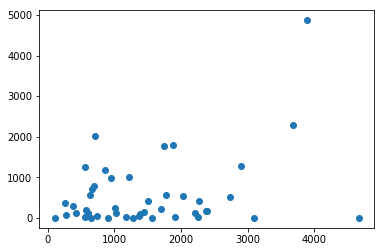

In [39]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns

plt.scatter(x= data['asian_pop'], y=data['ffall'])



,ffall,asian_pop
ffall,1.00000,0.34704
asian_pop,0.34704,1.00000


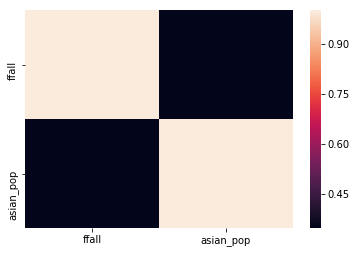

In [40]:
sns.heatmap(data.corr())
data.corr()